In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk

import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox, TextArea)
from matplotlib.patches import ArrowStyle 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from yahoo_fin.stock_info import get_data
#from nltk.stem import PorterStemmer


In [107]:
df_nonClean = pd.read_csv("Financial Tweets.csv", encoding='iso-8859-1')
df_nonClean.sample(n=18)

,Sentiment,Tweets
324765,negative,goodmorning! just took a shower. now gonna hav...
156032,negative,@Marielhemingway me too. Been a long week. Jus...
777486,negative,shocked beyond belief that SPAIN lost to the U...
675762,negative,Ugh. Rain.
578191,negative,. @geektyrant I love your site. I really do. Y...
1041043,positive,prayin' to wake up to a few sales tomorrow mor...
121158,negative,Oh no I forgot to make a wish at 11:11 ( now I...
33378,negative,Rainy dayy
107941,negative,@lawerca nope! ive gone to every tour since be...
365931,negative,"No Yankees game 2day, we got rained out"


<BarContainer object of 2 artists>

<Figure size 432x288 with 0 Axes>

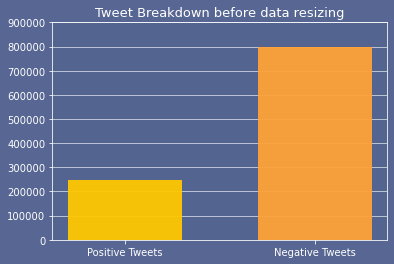

In [102]:
pos_tweet_count = len(df_nonClean.loc[df_nonClean['Sentiment'] == 'positive'])
neg_tweet_count = len(df_nonClean.loc[df_nonClean['Sentiment'] == 'negative'])
plt.rcParams["figure.figsize"] = [6, 4]
plt.rc('axes', titlesize=13)
fig = plt.figure(facecolor='#576692')
fig, ax = plt.subplots(facecolor='#576692')
ax.set_facecolor('#536490')
ax.set_ylim(0, 900000)
ax.grid(axis = 'y', zorder = '1', c = 'w', alpha = 1, lw = .6)
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
ax.yaxis.label.set_color('w')
ax.xaxis.label.set_color('w')
ax.title.set_color('w')
ax.set_title("Tweet Breakdown before data resizing")
ax.bar(["Positive Tweets", "Negative Tweets"], [pos_tweet_count, neg_tweet_count], color = ['#ffc801', '#ffa238'],width = .6, zorder = 3, alpha = .95)

# Resizing the Data
This data has 2 problems.
    
    1) This data has 1.4 million tweets. It will take a long for my laptop to process 1.4 million tweets.
    
    2) This also have a uneven amount of postive and negative tweets. If I run the data without balancing it out, the model will be baised towards negative tweets.

To solve the problem, I will first split the data set into two smaller data sets called "df_nonClean_pos" that represent postive tweets, and "df_nonClean_neg" that represent negative tweets. Then I will take a random sample of 25,000 tweets from each data sets and then combine the two data sets again. So now, I will have a data set of 50,000 tweets, with 25,000 negative and 25,000 positive tweets.

In [5]:
df_nonClean_pos = df_nonClean.loc[df_nonClean['Sentiment'] == "positive"]
df_nonClean_neg = df_nonClean.loc[df_nonClean['Sentiment'] == "negative"]

df_nonClean_pos = df_nonClean_pos.sample(frac=25000/df_nonClean_pos.shape[0])
df_nonClean_neg = df_nonClean_neg.sample(frac=25000/df_nonClean_neg.shape[0])

df_nonClean = pd.concat([df_nonClean_pos, df_nonClean_neg])


In [6]:
def words_to_label(s):
    if s == "negative":
        return 0
    elif s ==  "positive":
        return 1

df_nonClean["Label"] = df_nonClean["Sentiment"].apply(words_to_label)
df_nonClean

,Sentiment,Tweets,Label
989209,positive,took a shower oh I luv luv luuuuv my new hair...,1
823888,positive,@PreciousN0thing LOL!! Ballz and nutsacks!! ...,1
876120,positive,Im getting ready to go up to LA. My lil sister...,1
1014779,positive,"@freshginger See you today, Lamai's at noon",1
827476,positive,@gaelicwolf That's good. You guys enjoy yourse...,1
...,...,...,...
289148,negative,is adding some stuff to her MySpace profile. I...,0
634900,negative,"@mwvw I got one person, too. BTW: New Nouvell...",0
170227,negative,@mtupyro - don't feel bad. I got a foad for a ...,0
80330,negative,@stephenluver13 ya but im tired so im gonna ge...,0


In [7]:
#cleaning the tweets
def clean_tweets(tweet):
    tweet = tweet. lower()
    tweet = re.sub("@[A-Za-z0-9]*", "", tweet)
    tweet = re.sub("["+string.punctuation+"]", "", tweet)
    tweet_tokens = word_tokenize(tweet)
    
    sw = stopwords.words("english")
    tweet_tokens_filtered = []
    for token in tweet_tokens:
        if token not in sw and token.isalpha():
            tweet_tokens_filtered.append(token)
            
    tweet = " ".join(tweet_tokens_filtered)
    return tweet

In [8]:
df_nonClean["Clean Tweets"] = df_nonClean["Tweets"].apply(clean_tweets)
df_clean = df_nonClean.drop(columns=["Sentiment", "Tweets"]).copy()
df_clean

,Label,Clean Tweets
989209,1,took shower oh luv luv luuuuv new haircut
823888,1,lol ballz nutsacks theres something else dont ...
876120,1,im getting ready go la lil sisters birthday pa...
1014779,1,see today lamais noon
827476,1,thats good guys enjoy
...,...,...
289148,0,adding stuff myspace profile wish baby
634900,0,got one person btw new nouvelle vague epic
170227,0,dont feel bad got foad promotion
80330,0,ya im tired im gon na get soon


In [9]:
#Vectorizeing the text
#use same on test data
my_tfidfVectorizer = TfidfVectorizer(use_idf=True)
X = my_tfidfVectorizer.fit(df_clean["Clean Tweets"])
#print(X.vocabulary_)
#print(my_tfidfVectorizer.get_feature_names())

X = my_tfidfVectorizer.transform(df_clean["Clean Tweets"])
y = df_clean["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
classifier_multinomialNB = MultinomialNB()
classifier_multinomialNB.fit(X_train, y_train)

predictions = classifier_multinomialNB.predict(X_test)

print(accuracy_score(y_test, predictions))

0.746


In [11]:
classifier_SGDClassifier = SGDClassifier()
classifier_SGDClassifier.fit(X_train, y_train)

predictions = classifier_SGDClassifier.predict(X_test)

print(accuracy_score(y_test, predictions))

0.7569


In [12]:
classifier_LR_model = LogisticRegression(max_iter=1000)
classifier_LR_model.fit(X_train, y_train)

predictions = classifier_LR_model.predict(X_test)

print(accuracy_score(y_test, predictions))

0.7616


In [13]:
def test_new_tweet(tweet):
    tweet_clean = clean_tweets(tweet)
    test_tweet = my_tfidfVectorizer.transform([tweet_clean])
    test_predict = classifier_LR_model.predict(test_tweet)
    print("Tweet: \''", tweet, "\''", sep='')
    if test_predict == 0:
        print("The tweet is negative")
    elif test_predict == 1:
        print("The tweet is postive")

def my_plot(ax, x_values, y_values, x_label, y_lable, title, tweetDate, y_value_at_tweet_date, image_name, img_offset, arrow_offset):
    plt.rc('axes', titlesize=15)     # fontsize of the axes title
    plt.rcParams["figure.figsize"] = [16,6]
    img = plt.imread(image_name, format='png')
    img = OffsetImage(img, zoom=.1)
    img = AnnotationBbox(img, [tweetDate,  y_value_at_tweet_date], xybox=img_offset, xycoords='data', boxcoords='offset pixels', pad=0,box_alignment=(0, 1), frameon=False)
    arrow = TextArea("")
    arrow = AnnotationBbox(arrow, [tweetDate,  y_value_at_tweet_date], xybox=arrow_offset, xycoords='data', pad=-10, boxcoords='offset pixels', frameon=False, arrowprops=dict(
                        arrowstyle='->',
                        color='w',
                    ))
    ax.add_artist(img)
    ax.add_artist(arrow)
    ax.set_facecolor('#FA8769')
    ax.plot(x_values, y_values, '-o', color = "#D94E48", linewidth=3, markersize=8)
    ax.axvline(tweetDate, linestyle =  ':', color = 'w')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_lable)
    ax.set_title(title)
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)

Tweet: ''Sooo does anyone else not open Snapchat anymore? Or is it just me... ugh this is so sad,''
The tweet is negative


<Figure size 1152x432 with 0 Axes>

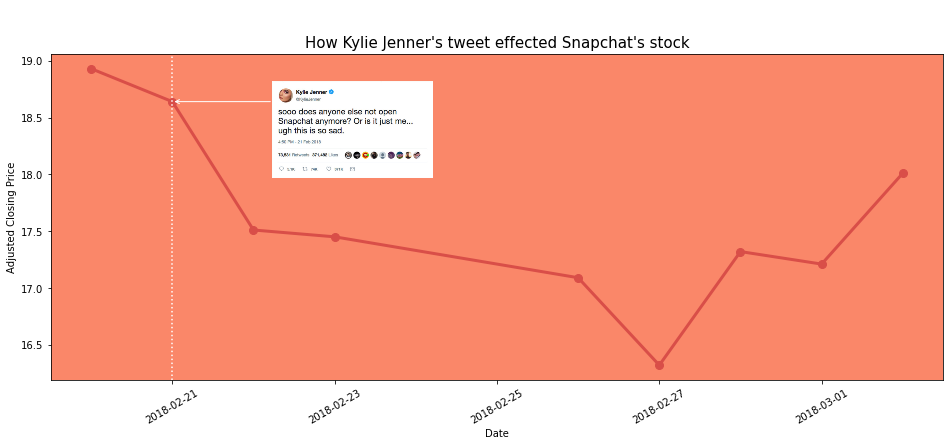

In [16]:
test_new_tweet("Sooo does anyone else not open Snapchat anymore? Or is it just me... ugh this is so sad,")
snap_data = get_data("SNAP", start_date = "02/20/2018", end_date = "03/3/2018", index_as_date=False)
fig = plt.figure()
fig, ax1 = plt.subplots(1)
my_plot(ax1, snap_data["date"], snap_data["adjclose"], "Date", "Adjusted Closing Price", "How Kylie Jenner's tweet effected Snapchat's stock", snap_data.iloc[1][0], snap_data.iloc[1][5], "kylie_jenner_tweet.png", [100, 20], [100, 0])

Tweet: ''We currently have a large position in APPLE. We believe the company to be extremely undervalued. Spoke to Tim Cook today. More to come.''
The tweet is postive


<Figure size 1152x432 with 0 Axes>

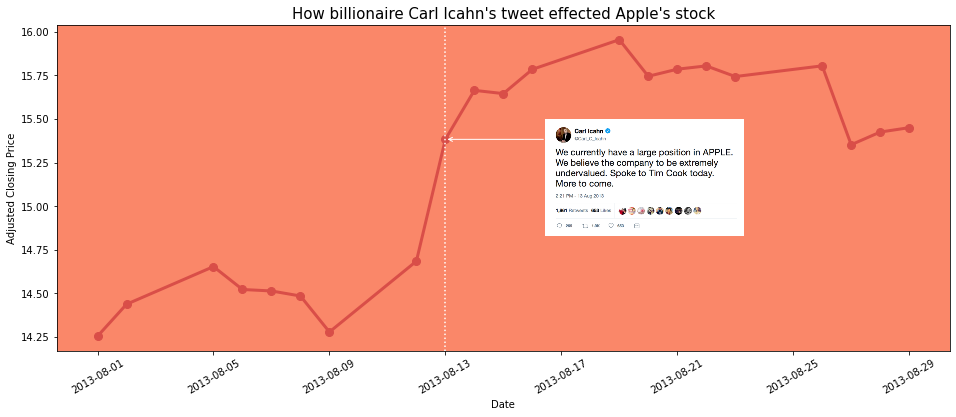

In [17]:
test_new_tweet("We currently have a large position in APPLE. We believe the company to be extremely undervalued. Spoke to Tim Cook today. More to come.")
appl_data = get_data("AAPL", start_date = "08/1/2013", end_date = "08/30/2013", index_as_date=False)
fig = plt.figure()
fig, ax1 = plt.subplots(1)
my_plot(ax1, appl_data["date"], appl_data["adjclose"], "Date", "Adjusted Closing Price", "How billionaire Carl Icahn's tweet effected Apple's stock", appl_data.iloc[8][0], appl_data.iloc[8][5], "carl_icahn_tweet.png", [100, 20], [100, 0])